In [397]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges
from tqdm import tqdm
from sklearn import metrics
from sklearn.cluster import KMeans

## Dataset
We use the Cora citations dataset, which consists of scientific publications classified into one of seven classes.

In [398]:
dataset = Planetoid(root='../data/', name='Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [415]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data.edge_index = dataset[0].edge_index
data

Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527], edge_index=[2, 10556])

## GAE Model
We define a simple Graph Autoencoder model with a two-layer GCN encoder. The GAE is already implemented in PyTorch Geometric, so we only need to define the encoder.

In [400]:
class GCNEncoder(nn.Module):
	def __init__(self, in_channels: int, latent_dim: int):
		super(GCNEncoder, self).__init__()
		self.conv1 = GCNConv(in_channels, 2 * latent_dim)
		self.conv2 = GCNConv(2 * latent_dim, latent_dim)

	def forward(self, x: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
		x = F.relu(self.conv1(x, edge_index))
		return self.conv2(x, edge_index)

### Using GAE for Link Prediction
We train the GAE model using the training data and validate it using the validation data. We use the ROC AUC and Average Precision scores to evaluate the model.

In [401]:
latent_dim, lr, epochs = 16, .01, 100

model = GAE(GCNEncoder(dataset.num_features, latent_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [402]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, x: torch.tensor, train_pos_edge_index: torch.tensor) -> float:
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

In [403]:
def test(pos_edge_index: torch.tensor, neg_edge_index: torch.tensor) -> tuple[float, float]:
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [404]:
losses, aucs, aps = [], [], []
for epoch in (pbar := tqdm(range(epochs), desc="Epochs")):
    loss = train(model, optimizer, data.x, data.train_pos_edge_index) 
    losses.append(loss)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    aucs.append(auc)
    aps.append(ap)
    pbar.set_postfix({"Loss": loss, "ROC AUC": auc, "Average Precision": ap})

Epochs: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s, Loss=0.83, ROC AUC=0.905, Average Precision=0.91] 


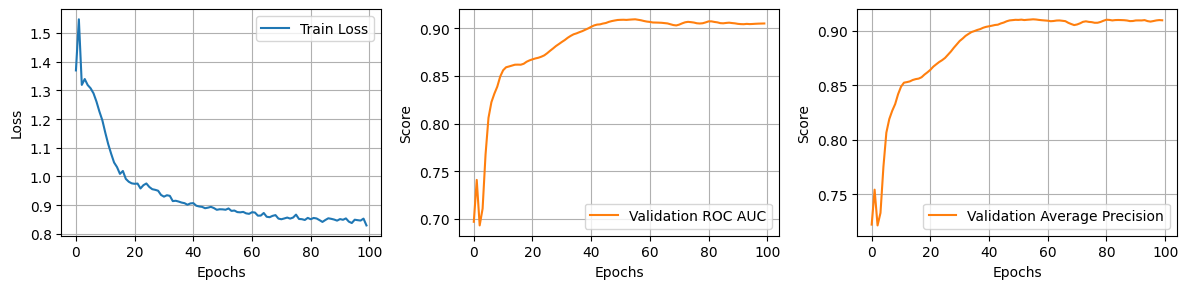

In [405]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(losses, label="Train Loss")
axs[1].plot(aucs, label="Validation ROC AUC", c="C1")
axs[2].plot(aps, label="Validation Average Precision", c="C1")
for i in range(3):
	axs[i].set_xlabel("Epochs")
	axs[i].set_ylabel("Loss" if i == 0 else "Score")
	axs[i].legend()
	axs[i].grid()
plt.tight_layout()
plt.show()

In [406]:
auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
print(f"Test ROC AUC: {auc:.4f}, Test Average Precision: {ap:.4f}")

Test ROC AUC: 0.9049, Test Average Precision: 0.9096


### Using GAE for Node Clustering

In [407]:
import torch
from sklearn.cluster import KMeans

# Assuming you have trained the model and obtained latent embeddings
# You can use these embeddings for clustering
with torch.no_grad():
    model.eval()
    z = model.encode(data.x, data.edge_index)

# Convert latent embeddings to numpy array
z_np = z.cpu().numpy()

# Perform K-means clustering
k = 7  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0).fit(z_np)

# Get cluster labels
cluster_labels = kmeans.labels_

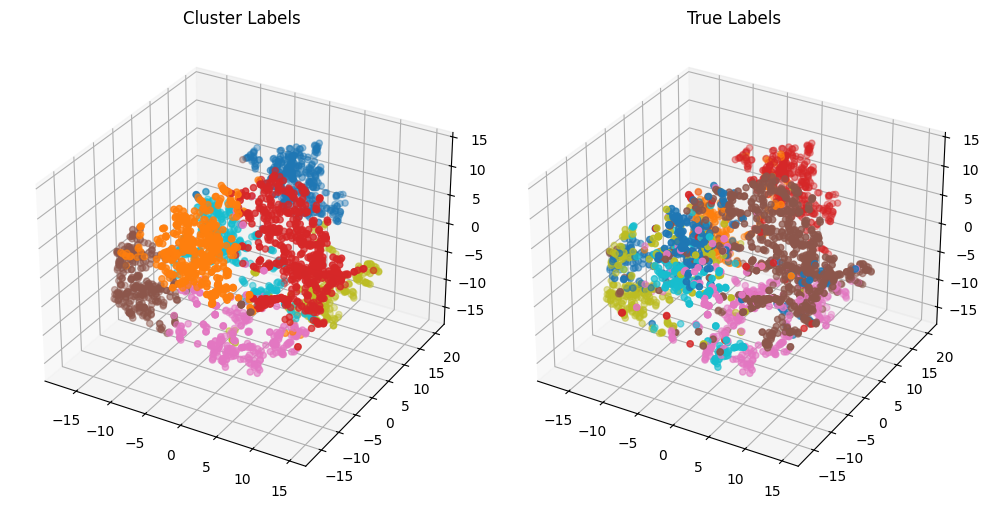

In [412]:
# Visualize the clusters in 3d
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Reduce the dimensionality of the embeddings for visualization
z_embedded = TSNE(n_components=3).fit_transform(z_np)

# Plot the clusters vs the true labels
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(z_embedded[:, 0], z_embedded[:, 1], z_embedded[:, 2], c=cluster_labels, cmap='tab10')
ax1.set_title("Cluster Labels")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(z_embedded[:, 0], z_embedded[:, 1], z_embedded[:, 2], c=data.y, cmap='tab10')
ax2.set_title("True Labels")

plt.tight_layout()
plt.show()

In [413]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Assuming you have trained the model and obtained latent embeddings
# You can use these embeddings for clustering
with torch.no_grad():
    model.eval()
    z = model.encode(data.x, data.edge_index)

# Convert latent embeddings to numpy array
z_np = z.cpu().numpy()

# Perform K-means clustering
k = 7  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0).fit(z_np)

# Get cluster labels
cluster_labels = kmeans.labels_

# Assuming you have true labels for evaluation
true_labels = dataset[0].y.numpy()

# Evaluate clustering using Silhouette Score
silhouette = silhouette_score(z_np, cluster_labels)
print("Silhouette Score:", silhouette)

# Evaluate clustering using Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)

# Evaluate clustering using Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
print("Normalized Mutual Information (NMI):", nmi)

# Compute accuracy
def compute_accuracy(true_labels, cluster_labels):
    # Create a mapping between cluster labels and true labels
    label_mapping = {}
    for cluster in np.unique(cluster_labels):
        # For each cluster, find the most common true label
        true_label = np.argmax(np.bincount(true_labels[cluster_labels == cluster]))
        label_mapping[cluster] = true_label
    
    # Map cluster labels to true labels
    mapped_labels = [label_mapping[cluster] for cluster in cluster_labels]
    
    # Compute accuracy
    accuracy = np.mean(np.array(true_labels) == np.array(mapped_labels))
    return accuracy

accuracy = compute_accuracy(true_labels, cluster_labels)
print("Accuracy:", accuracy)


Silhouette Score: 0.33727542
Adjusted Rand Index (ARI): 0.39774197124934774
Normalized Mutual Information (NMI): 0.4312598944010633
Accuracy: 0.6344165435745938
